In [52]:
from functools import partial
import os
import argparse
import yaml

import torch
import matplotlib.pyplot as plt
import csv
import os
from torch.fft import fftn, ifftn, fftshift, ifftshift
import torch.nn as nn
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np

from torchvision.transforms import transforms, InterpolationMode, Resize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def normalize_np(img):
    """ Normalize img in arbitrary range to [0, 1] """
    img -= np.min(img)
    img /= np.max(img)
    return img
def clear_color(x):
    if torch.is_complex(x):
        x = torch.abs(x)
    x = x.detach().cpu().squeeze().numpy()
    return normalize_np(np.transpose(x, (1, 2, 0)))

class FourierTransformModel(nn.Module):
    def __init__(self):
        super(FourierTransformModel, self).__init__()

    def forward(self, x, cutoff_lower, cutoff_upper):
        channel_fft = fftn(x, dim=(-2, -1),norm='ortho')
        channel_fft_shifted = fftshift(channel_fft, dim=(-2, -1))
    
        # Apply a low-pass filter
        _, c, h, w = x.shape
        mask = self.create_low_pass_mask(h, w, cutoff_lower, cutoff_upper)
        mask = mask.unsqueeze(0).unsqueeze(0).repeat(1, 3, 1, 1).to(device)
        channel_fft_shifted_filtered = channel_fft_shifted * mask
        
        # Shift back the zero frequency component
        channel_fft_filtered = ifftshift(channel_fft_shifted_filtered, dim=(-2, -1))

        channel_fft_log =  channel_fft_filtered
        # channel_fft_log = torch.log(channel_fft_filtered)            
        return channel_fft_log
    
    def create_low_pass_mask(self, height, width, cutoff_lower, cutoff_upper):
        y, x = torch.meshgrid(torch.arange(-height//2, height//2), torch.arange(-width//2, width//2))
        distance = torch.sqrt(x**2 + y**2)
        mask = ((distance > cutoff_lower) & (distance < cutoff_upper)).float()
        return mask


class InverseFourierTransformModel(nn.Module):
    def __init__(self):
        super(InverseFourierTransformModel, self).__init__()

    def forward(self, x):

        channel_fft_exp = x
        # channel_fft_exp = torch.exp(x)
        channel_reconstructed = ifftn(channel_fft_exp, dim=(-2, -1),norm='ortho')
        channel_reconstructed_real = channel_reconstructed.real
        min_val = channel_reconstructed_real.amin(dim=(-2, -1), keepdim=True)
        max_val = channel_reconstructed_real.amax(dim=(-2, -1), keepdim=True)
        channel_reconstructed_normalized = (channel_reconstructed_real - min_val) / (max_val - min_val + 1e-7)
        
        channel_reconstructed_uint8 = (channel_reconstructed_normalized * 255.0).to(torch.float64)

        return channel_reconstructed_uint8


class CombinedFourierModel(nn.Module):
    def __init__(self, fourier_model, inverse_fourier_model):
        super(CombinedFourierModel, self).__init__()
        self.fourier_model = fourier_model  # Fourier Transform Model
        self.inverse_fourier_model = inverse_fourier_model  # Inverse Fourier Transform Model

    def forward(self, x, lower, upper):
        # Apply the Fourier Transform model
        lower = torch.tensor(lower)
        upper = torch.tensor(upper)
        transformed = self.fourier_model(x,cutoff_lower=lower,cutoff_upper=upper)
        
        # Apply the Inverse Fourier Transform model
        reconstructed = self.inverse_fourier_model(transformed)
        
        return reconstructed

fourierModel = FourierTransformModel()
fourierModel = fourierModel.to(device)
fourierModel.eval()

inv_fourierModel = InverseFourierTransformModel()
inv_fourierModel = inv_fourierModel.to(device)
inv_fourierModel.eval()

combined_model = CombinedFourierModel(fourierModel, inv_fourierModel)
combined_model = combined_model.to(device)
combined_model.eval()
transform = transforms.Compose([transforms.ToTensor(),
                                Resize((256,256), interpolation=InterpolationMode.BICUBIC),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

from PIL import Image
import numpy as np

image = Image.open("/home/abhi2358/code/project/PnPInversion/data/annotation_images/1_change_object_80/1_artificial/1_animal/111000000000.jpg")
image = transform(image).to(device).unsqueeze(0)
lower = 0
upper = 40
recon = combined_model(image, lower, upper)  




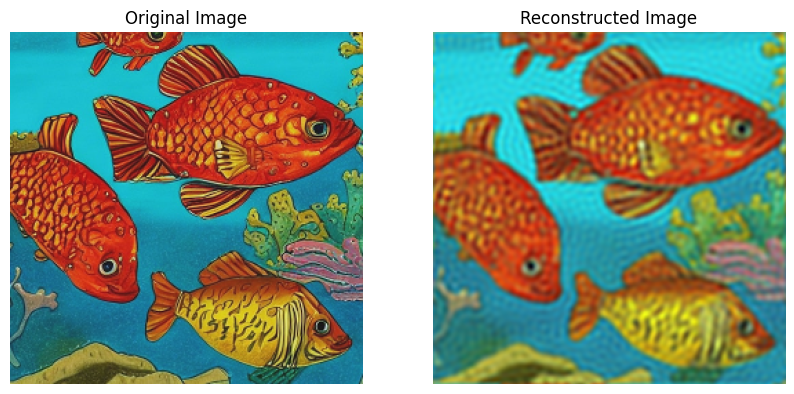

In [53]:
#plot reconstructed image and original image together
recon = clear_color(recon)
image = clear_color(image)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(recon)
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()

In [ ]:

import torch.nn as nn
from torch.fft import fftn, ifftn, fftshift, ifftshift
from abc import ABC, abstractmethod
import numpy as np
class FourierTransformModel(nn.Module):
        def __init__(self,device):#, mask_type, device):
            super(FourierTransformModel, self).__init__()
            # self.mask_type = mask_type
            self.device = device

        def get_mask(self, mags, cutoff):
            # (mag_r, mag_g, mag_b) = mags
            # h, w = mag_r.shape
            # C =len(mags)
            N, C, h, w = mags.shape 
            y, x = torch.meshgrid(torch.arange(-h//2, h//2), torch.arange(-w//2, w//2), indexing='ij')
            distance = torch.sqrt(x**2 + y**2)
            mask = (distance < cutoff).float()
            mask = mask.unsqueeze(0).unsqueeze(0).repeat(1, C, 1, 1).to(self.device)
            
            return mask

        def forward(self, x, cutoff):
            channel_fft = fftn(x, dim=(-2, -1),norm='ortho')
            channel_fft_shifted = fftshift(channel_fft, dim=(-2, -1))
        
            _, c, h, w = x.shape
            
            mask = self.get_mask(x, cutoff)
            # import pdb; pdb.set_trace()
            channel_fft_shifted_filtered = channel_fft_shifted * mask
            
            # Shift back the zero frequency component
            channel_fft_filtered = ifftshift(channel_fft_shifted_filtered, dim=(-2, -1))
            
            # channel_fft_log = torch.log(channel_fft_filtered)            
            return channel_fft_filtered
    



class ConditioningMethod(ABC):
    def __init__(self):#, operator, noiser, **kwargs):
        # self.operator = operator
        # self.noiser = noiser
        pass

    
    def grad_and_value(self, x_prev, x_pred, image_gt, t,cutoff_schedule=None,model=None,cond_model=None,  **kwargs):
        cutoff = cutoff_schedule[t.cpu()]

        # image_tensor = image2tensor(model, image_gt)

        #reshape images to 256x256
        difference = cond_model(image_gt, cutoff) \
                - cond_model(x_pred, cutoff)
        ###check image_gt requires_grad
        with torch.autograd.set_detect_anomaly(True):
            norm = torch.linalg.norm(difference)
            norm_grad = torch.autograd.grad(outputs=norm, inputs=x_prev)[0]
        return norm_grad, norm

class ModelPosteriorSampling(ConditioningMethod):
    def __init__(self, model, cond_model, schedule, start_bound, end_bound,scale_schedule,scale_start, scale_end ,**kwargs):
        super().__init__()

        self.scale_schedule = scale_schedule  #kwargs.get('scale_schedule', None)
        if self.scale_schedule=="fixed":
            self.scale = scale_start
        else:
            # Having learning rate for each time step
            # Parameters
            a = scale_start    # Initial value
            b = scale_end    # Minimum value
            T = 1000   # Total time steps
            time_steps = np.linspace(0, T, T)
            annealing_values = 0.5 * (a + b) + 0.5 * (a - b) * np.cos(np.pi * time_steps / T)
            self.scale = torch.tensor(annealing_values).to("cuda")
        
        self.model = model
        self.cond_model = cond_model
        if schedule == 'linear':
            self.cutoff_schedule = torch.linspace(start_bound, end_bound, 1000).flip(0)
        elif schedule == 'cosine':
            self.cutoff_schedule = (end_bound - (end_bound - start_bound) * torch.exp(-torch.linspace(0, 5, 1000))).flip(0)
        else:
            raise NotImplementedError("Only linear schedule is currently supported for ModelPosteriorSampling.")


    def conditioning(self, target_latent_prev, x_pred, image_gt, target_latent, t, **kwargs):
        norm_grad, norm = self.grad_and_value(x_prev=target_latent_prev, x_pred=x_pred, image_gt=image_gt, \
                                t=t, cutoff_schedule=self.cutoff_schedule, model=self.model,cond_model=self.cond_model , **kwargs)
        
        if self.scale_schedule=="fixed":
            target_latent = target_latent - (norm_grad * (self.scale))
            scaled_norm_grad = norm_grad * (self.scale)
        else:
            target_latent = target_latent - (norm_grad * (self.scale[t]))
            scaled_norm_grad = norm_grad * (self.scale[t])
        
        print("distance at time t {} is {}".format(t, norm))
        return target_latent, scaled_norm_grad


import os

class FGPSInversion:
    
    def prev_step(self, model_output, timestep: int, sample, image_gt = None, save_path = None):
        prev_timestep = timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.scheduler.final_alpha_cumprod
        beta_prod_t = 1 - alpha_prod_t
        pred_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        pred_sample_direction = (1 - alpha_prod_t_prev) ** 0.5 * model_output
        prev_sample = alpha_prod_t_prev ** 0.5 * pred_original_sample + pred_sample_direction
        with torch.no_grad():
            x_start_pred_img_pil = Image.fromarray(latent2image(self.model.vae, pred_original_sample)[0])

        name = os.path.basename(save_path)
        #remove the extension
        name = os.path.splitext(name)[0]
        path = os.path.dirname(save_path) + f"/{name}/inverts/x_start_pred_{timestep}.png"
        if not os.path.exists(os.path.dirname(path)):
            os.makedirs(os.path.dirname(path))
        x_start_pred_img_pil.save(path)

        gt_latent = image2latent(self.model.vae, image_gt)

        fourier_model = FourierTransformModel(self.model.device)
        fourier_model = fourier_model.to(self.model.device)
        fourier_model.eval()
        cond_model = fourier_model
        scale_schedule = "cosine"
        
        freq_start = 10
        freq_end = 100
        scale_start = 3.0
        scale_end = 0.01

        if timestep>900:
            print(f"scale schedule is {scale_schedule}, scale start is {scale_start}, scale end is {scale_end}, freq start is {freq_start}, freq end is {freq_end}")

        conditioning_method = ModelPosteriorSampling(self.model, cond_model, 'cosine', freq_start, freq_end, scale_schedule=scale_schedule, scale_start=scale_start, scale_end=scale_end)
        prev_sample, scaled_norm_grad = conditioning_method.conditioning(target_latent_prev=sample, x_pred=pred_original_sample, image_gt=gt_latent, target_latent=prev_sample, t=timestep)


        return prev_sample, scaled_norm_grad
    
    def next_step(self, model_output, timestep: int, sample):
        timestep, next_timestep = min(timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps, 999), timestep
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep] if timestep >= 0 else self.scheduler.final_alpha_cumprod
        alpha_prod_t_next = self.scheduler.alphas_cumprod[next_timestep]
        beta_prod_t = 1 - alpha_prod_t
        next_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        next_sample_direction = (1 - alpha_prod_t_next) ** 0.5 * model_output
        next_sample = alpha_prod_t_next ** 0.5 * next_original_sample + next_sample_direction
        return next_sample
    
    def get_noise_pred_single(self, latents, t, context):
        noise_pred = self.model.unet(latents, t, encoder_hidden_states=context)["sample"]
        return noise_pred

    @torch.no_grad()
    def init_prompt(self, prompt: str):
        uncond_input = self.model.tokenizer(
            [""], 
            padding="max_length", 
            max_length=self.model.tokenizer.model_max_length,
            return_tensors="pt"
        )
        uncond_embeddings = self.model.text_encoder(uncond_input.input_ids.to(self.model.device))[0]
        text_input = self.model.tokenizer(
            [prompt],
            padding="max_length",
            max_length=self.model.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.model.text_encoder(text_input.input_ids.to(self.model.device))[0]
        self.context = torch.cat([uncond_embeddings, text_embeddings])
        self.prompt = prompt

    @torch.no_grad()
    def ddim_loop(self, latent):
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        all_latent = [latent]
        latent = latent.clone().detach()
        for i in range(self.num_ddim_steps):
            t = self.model.scheduler.timesteps[len(self.model.scheduler.timesteps) - i - 1]
            noise_pred = self.get_noise_pred_single(latent, t, cond_embeddings)
            latent = self.next_step(noise_pred, t, latent)
            all_latent.append(latent)
        return all_latent

    @property
    def scheduler(self):
        return self.model.scheduler

    @torch.no_grad()
    def ddim_inversion(self, image):
        latent = image2latent(self.model.vae, image)
        image_rec = latent2image(self.model.vae, latent)[0]
        ddim_latents = self.ddim_loop(latent)
        return image_rec, ddim_latents

    
    def grad_offset_calculate(self, latents, num_inner_steps, epsilon, guidance_scale, image_gt, save_path):
        scaled_norm_grad_list = []
        latent_cur = torch.concat([latents[-1]]*(self.context.shape[0]//2))
        latent_cur = latent_cur.requires_grad_(True)
        for i in range(self.num_ddim_steps):            
            t = self.model.scheduler.timesteps[i]
            with torch.no_grad():
                noise_pred = self.get_noise_pred_single(torch.concat([latent_cur]*2), t, self.context)
                noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
                noise_pred_w_guidance = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)
            latents_prev_rec, scaled_norm_grad = self.prev_step(noise_pred_w_guidance, t, latent_cur, image_gt, save_path)
            
            scaled_norm_grad_list.append(scaled_norm_grad.detach())
            latent_cur = latents_prev_rec
        return scaled_norm_grad_list
    
    def invert(self, image_gt, prompt, guidance_scale, num_inner_steps=10, early_stop_epsilon=1e-5,save_path=None):
        self.init_prompt(prompt)
        register_attention_control(self.model, None)
        
        image_rec, ddim_latents = self.ddim_inversion(image_gt)
        scaled_norm_grad_list = self.grad_offset_calculate(ddim_latents, num_inner_steps, early_stop_epsilon,guidance_scale, image_gt, save_path)
        # uncond_embeddings = self.null_optimization(ddim_latents, num_inner_steps, early_stop_epsilon,guidance_scale)
        return image_gt, image_rec, ddim_latents, scaled_norm_grad_list
    
    def __init__(self, model,num_ddim_steps):
        self.model = model
        self.tokenizer = self.model.tokenizer
        self.prompt = None
        self.context = None
        self.num_ddim_steps=num_ddim_steps
        


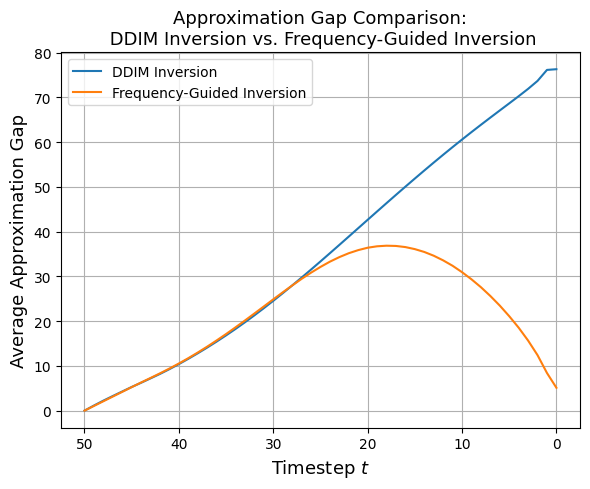

In [4]:
import pandas as pd

# File containing the distances
file_name1 = "/home/abhi2358/code/project/PnPInversion/models/l2_distances.csv"

# Read the CSV file into a DataFrame
df1= pd.read_csv(file_name1)

# Calculate the average across the rows
column_averages1 = df1.mean(axis=1)

# File containing the distances
file_name2 = "/home/abhi2358/code/project/PnPInversion/models/l2_distances_fgps.csv"

# Read the CSV file into a DataFrame
df2= pd.read_csv(file_name2)

# Calculate the average across the rows
column_averages2 = df2.mean(axis=1)
import matplotlib.pyplot as plt

# Plot the row-wise averages for the first file
plt.figure(figsize=(6, 5))
plt.plot(column_averages1, label='DDIM Inversion', linestyle='-')
plt.plot(column_averages2, label='Frequency-Guided Inversion', linestyle='-')

# Adding labels, title, and legend
plt.xlabel('Timestep $t$', fontsize=13)
plt.ylabel('Average Approximation Gap', fontsize=13)
plt.title('Approximation Gap Comparison:\n DDIM Inversion vs. Frequency-Guided Inversion', fontsize=13)
plt.legend()
plt.grid(True)
# Reverse the x-axis labels without inverting the data
x_ticks = range(len(column_averages1))
plt.xticks(x_ticks[::10], labels=x_ticks[::-1][::10])
# Show the plot
plt.tight_layout()
plt.show()